Training the model

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [24]:
pip install pytictoc

In [3]:
import numpy as np
import keras
import sklearn as sk
import cv2
from keras.applications.resnet import ResNet50
from keras.utils.vis_utils import plot_model
from keras.models import Model
from keras.layers import Input, Dense, Flatten, LSTM, ConvLSTM2D, Reshape, Conv2D, Dropout, BatchNormalization
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.layers.wrappers import TimeDistributed
import glob
import os
import tensorflow as tf
import json
from keras.models import model_from_json

Using TensorFlow backend.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#Load data with npy formats
X = np.load("/content/drive/My Drive/CSCE636/3_Dataset/raw_data.npy")
y = np.load("/content/drive/My Drive/CSCE636/3_Dataset/raw_label.npy")
times = np.load("/content/drive/My Drive/CSCE636/3_Dataset/times.npy")

In [ ]:
len(X)

5900

In [ ]:
#X = X/255

In [6]:
#Generating 20 frames out of each videos
num_frames = 20
len_X = len(X)
num_videos = len_X/num_frames
#70% of data splitted for training 30% for testing
percentage = 0.7

In [7]:
#splitting the data
X_train = X[:int(percentage*num_videos)*num_frames]
y_train = y[:int(percentage*num_videos)*num_frames]
X_test = X[int(percentage*num_videos)*num_frames:]
y_test = y[int(percentage*num_videos)*num_frames:]
times_train = times[:int(percentage*num_videos)*num_frames]
times_test = times[int(percentage*num_videos)*num_frames:]

In [8]:
#applying transfer learnign (the first layer is removed)
ResNet = ResNet50(include_top=False)

ResNet50_Model_base = Model(inputs = ResNet.input, outputs = ResNet.get_layer("conv5_block3_add").output)

all_layers = ResNet50_Model_base.layers

for layer in ResNet50_Model_base.layers:
    layer.trainable = False #ResNets weights will not be trained

#Assuming the input frames have the Height: 224 and Width: 224 pixels
Input_to_ResNet = Input(shape=(224, 224, 3),name = 'ResNet50')

ResNet_last_layer = ResNet50_Model_base(Input_to_ResNet)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

94773248/94765736 [==============================] - 2s 0us/step


In [9]:
#showing the last layer in ResNet
ResNet.output_names

['conv5_block3_out']

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


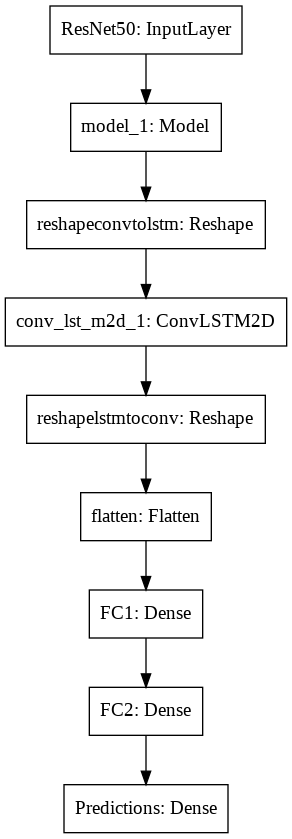

In [10]:
x = ResNet_last_layer #Modified ResNet

#Add the fully-connected layers 
conv_to_LSTM_dims = (1,7,7,2048)
x = Reshape(target_shape=conv_to_LSTM_dims, name='reshapeconvtolstm')(x)
x = ConvLSTM2D(filters=8, kernel_size=(3, 3), input_shape=(None, 20, 7, 7, 2048), padding='same')(x)  #input_shape=(samples, time, rows, cols, channels)

LSTM_to_conv_dims = (7,7,8)
x = Reshape(target_shape=LSTM_to_conv_dims, name='reshapelstmtoconv')(x)

x = Flatten(name='flatten')(x)
x = Dense(512, activation='relu', name='FC1')(x)
x = Dense(1024, activation='relu', name='FC2')(x)
x = Dense(1, activation='sigmoid', name='Predictions')(x) #1 for binary output
ResNet_for_TL = Model(Input_to_ResNet, x)
ResNet_for_TL.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

plot_model(ResNet_for_TL)

In [11]:
ResNet_for_TL.fit(x=X_train, y = y_train, batch_size=10, epochs=20, validation_data=(X_test, y_test))


Train on 4120 samples, validate on 1780 samples
Epoch 1/20
4120/4120 [==============================] - 28s 7ms/step - loss: 0.1376 - accuracy: 0.9505 - val_loss: 1.9235 - val_accuracy: 0.5848
Epoch 2/20
4120/4120 [==============================] - 20s 5ms/step - loss: 0.1064 - accuracy: 0.9633 - val_loss: 0.3692 - val_accuracy: 0.8303
Epoch 3/20
4120/4120 [==============================] - 20s 5ms/step - loss: 0.0601 - accuracy: 0.9765 - val_loss: 0.3765 - val_accuracy: 0.8719
Epoch 4/20
4120/4120 [==============================] - 20s 5ms/step - loss: 0.0470 - accuracy: 0.9854 - val_loss: 0.2365 - val_accuracy: 0.9337
Epoch 5/20
4120/4120 [==============================] - 20s 5ms/step - loss: 0.0296 - accuracy: 0.9913 - val_loss: 0.2788 - val_accuracy: 0.9073
Epoch 6/20
4120/4120 [==============================] - 19s 5ms/step - loss: 0.0424 - accuracy: 0.9869 - val_loss: 0.7034 - val_accuracy: 0.7135
Epoch 7/20
4120/4120 [==============================] - 20s 5ms/step - loss: 0.05

In [12]:
ResNet50_Model_base.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
plot_model(ResNet50_Model_base)

In [ ]:
ResNet.output_names

['conv5_block3_out']

In [13]:
# serialize model to JSON
ResNet50_json = ResNet_for_TL.to_json()
with open("/content/drive/My Drive/CSCE636/3_Saved_Model/ResNet50.json", "w") as json_file:
    json_file.write(ResNet50_json)
# serialize weights to HDF5
ResNet_for_TL.save_weights("/content/drive/My Drive/CSCE636/3_Saved_Model/Weights/ResNet50.h5")
print("Saved model to disk")

Saved model to disk


In [14]:

# load json and create model
ResNet50_json_file = open('/content/drive/My Drive/CSCE636/3_Saved_Model/ResNet50.json', 'r')
loaded_model_json = ResNet50_json_file.read()
ResNet50_json_file.close()
ResNet50_loaded = model_from_json(loaded_model_json)
# load weights into new model
ResNet50_loaded.load_weights("/content/drive/My Drive/CSCE636/3_Saved_Model/Weights/ResNet50.h5")
print("Loaded model from disk")

Loaded model from disk


In [15]:
u_test = ResNet50_loaded.predict((X_test))

In [16]:
y_test[80:160]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [17]:
ResNet50_loaded.predict(X_test[90].reshape(1,224,224,3))

array([[0.8276473]], dtype=float32)

In [19]:
json_array = np.stack((times_test, np.reshape(u_test, (-1,))), axis = 1)
json_list = np.ndarray.tolist(json_array)
json_dict = {"clap": json_list}
with open('/content/drive/My Drive/CSCE636/3_JSON/timeLabel.json', 'w') as outfile:
    json.dump(json_dict, outfile)

In [20]:
u_test

array([[0.40002245],
       [0.9835026 ],
       [0.6135975 ],
       ...,
       [0.82226104],
       [0.0224618 ],
       [0.02684119]], dtype=float32)

In [22]:
path_test = "/content/drive/My Drive/CSCE636/3_test/9_test.mp4"

In [45]:
####################new for loop


time_print = pytictoc.TicToc()
time_print.tic()
videos = []
labels_2d = []
num_frames = 100
frame_rate = 5
time_3d = []
time_2d = []
############################# Videos with label = 1
i=0
for path in glob.glob('/content/drive/My Drive/CSCE636/5_test/*.mp4'):
  
  vidcap = cv2.VideoCapture(path)
  fps = vidcap.get(cv2.CAP_PROP_FPS)
  success, image = vidcap.read()
  frames = []
  

  time = []
  count = 0  # control to have the same number of frames
  count_fps = 0
  while success:
    
    
    success, image = vidcap.read()
    count += 1
    if(type(image).__module__ == np.__name__):
      new_image = cv2.resize(image, (224,224), interpolation = cv2.INTER_AREA)
      
      frames.append(new_image)
      time.append(count_fps*(1/fps))
      count_fps += 1
      if count==num_frames:
        count_fps = 0
        # print("Frames_", str(count),", video_", str(i), "Done, Time_Elapsed: ", str(round(time_print.tocvalue(),3)), " Seconds")
        videos.append(frames)
        time_3d.append(time)
        count = 0
        frames = []
        time = []

  if (count < num_frames):
    while (count > 0 and count <= num_frames):
      frames.append(new_image)    # if the number of frames is lower than the num_frames, repeat the last image to reach num_frames
      count +=1
      time.append(count_fps*(1/fps))
      count_fps += 1
      
    videos.append(frames)
    time_3d.append(time)
  
  i+=1
  # print("Video_", str(i),"Done, Time_Elapsed: ", str(round(time_print.tocvalue(),3)), " Seconds")


videos_2d_len = len(videos)

############################# Videos with label = 0
i=0
for path in glob.glob('/content/drive/My Drive/CSCE636/3_Video_Cutting/0/*.mp4'):
  if(i == 219):
    break
  
  vidcap = cv2.VideoCapture(path)
  fps = vidcap.get(cv2.CAP_PROP_FPS)
  success, image = vidcap.read()
  frames = []
  
  time = []
  count = 0  # control to have the same number of frames
  count_fps = 0
  while success:
    
    success, image = vidcap.read()
    count += 1
    if(type(image).__module__ == np.__name__):
      new_image = cv2.resize(image, (224,224), interpolation = cv2.INTER_AREA)
    
      frames.append(new_image)
      time.append(count_fps*(1/fps))
      count_fps += 1
      if count==num_frames:
        count_fps = 0
        # print("Frames_", str(count),", video_", str(i), "Done, Time_Elapsed: ", str(round(time_print.tocvalue(),3)), " Seconds")
        videos.append(frames)
        time_3d.append(time)
        count = 0
        frames = []
        time = []


  if (count < num_frames):
    while (count > 0 and count <= num_frames):
      frames.append(new_image)    # if the number of frames is lower than the num_frames, repeat the last image to reach num_frames
      count +=1
      time.append(count_fps*(1/fps))
      count_fps += 1
      
    videos.append(frames)
    time_3d.append(time)

  i+=1
  # print("Video_", str(i),"Done, Time_Elapsed: ", str(round(time_print.tocvalue(),3)), " Seconds")

videos_3d = np.array(videos)

labels_2d = np.zeros((len(videos_3d),num_frames))
labels_2d[0:videos_2d_len,:] = 1

time_3d = np.array(time_3d)





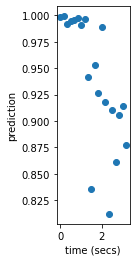

[0.9521286]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


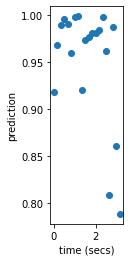

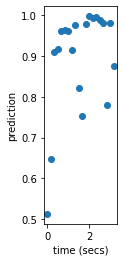

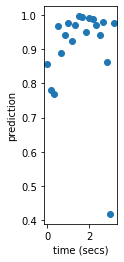

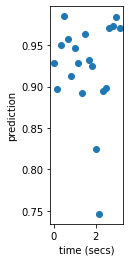

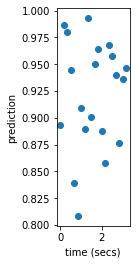

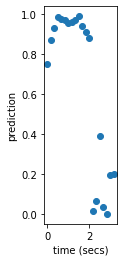

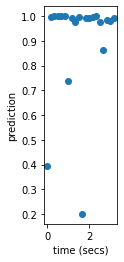

[0.98940957]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


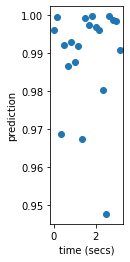

[0.9761545]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


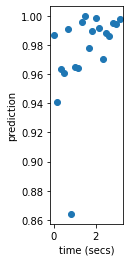

[0.9820677]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


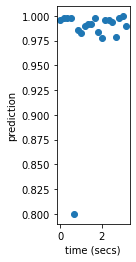

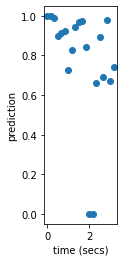

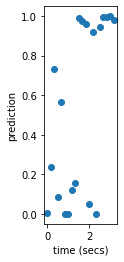

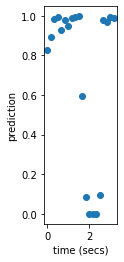

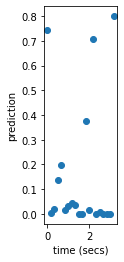

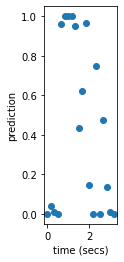

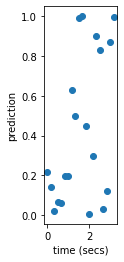

[0.95209104]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


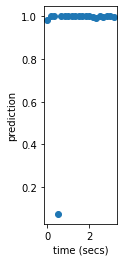

[0.9997386]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


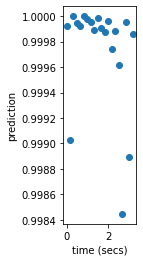

[0.99089956]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


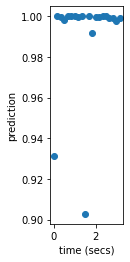

[0.9995824]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


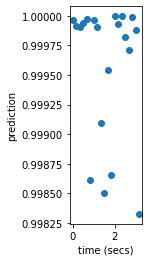

[0.9987055]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


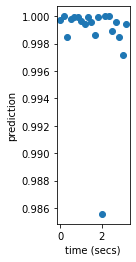

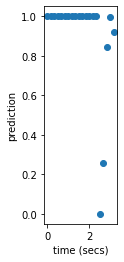

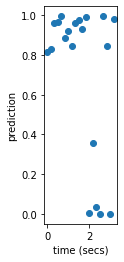

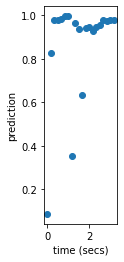

[0.95274466]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


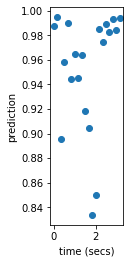

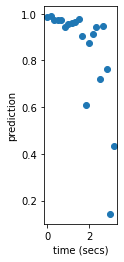

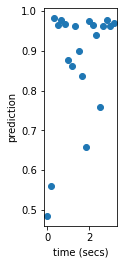

[0.9731738]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


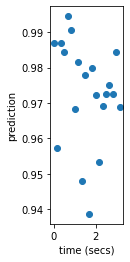

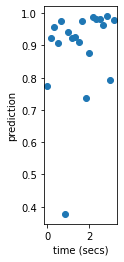

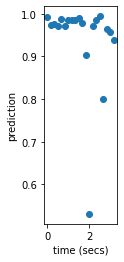

[0.97561705]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


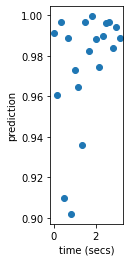

[0.9770981]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


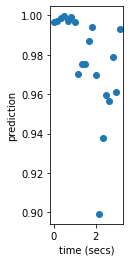

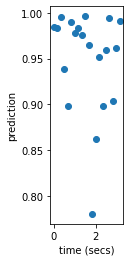

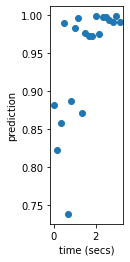

[0.9899907]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


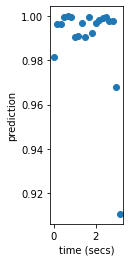

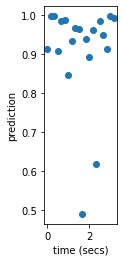

[0.9961197]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


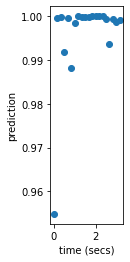

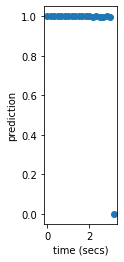

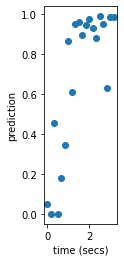

[0.96845007]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


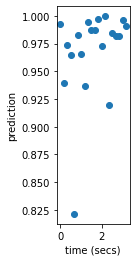

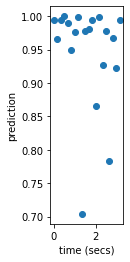

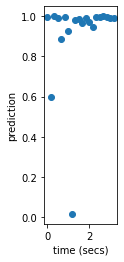

[0.98842174]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


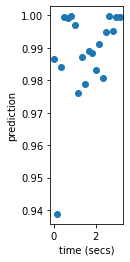

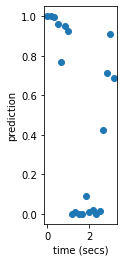

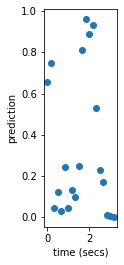

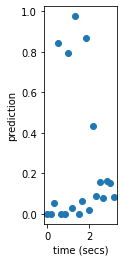

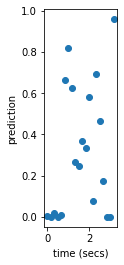

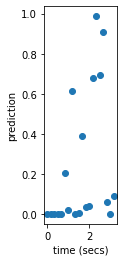

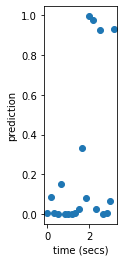

[0.98563874]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


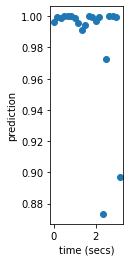

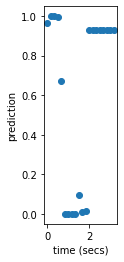

[0.9999975]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


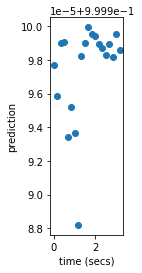

[0.9904936]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


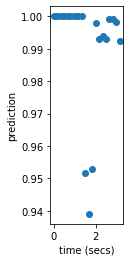

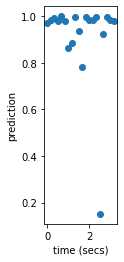

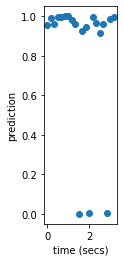

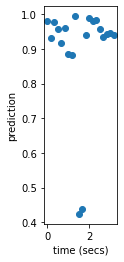

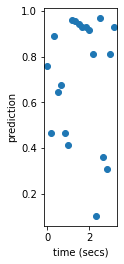

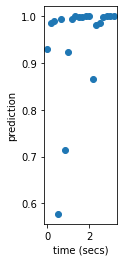

[0.9892257]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


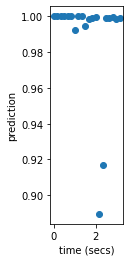

[0.9994276]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


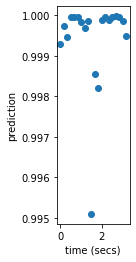

[0.99962986]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


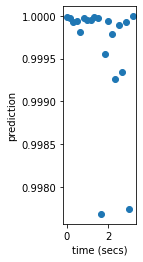

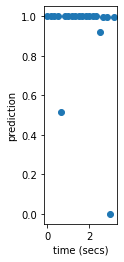

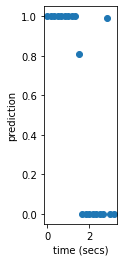

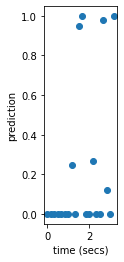

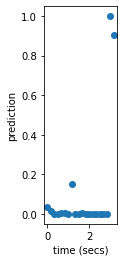

[0.950662]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


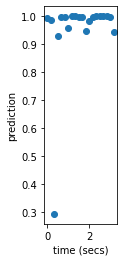

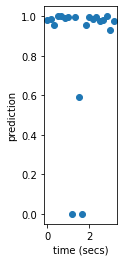

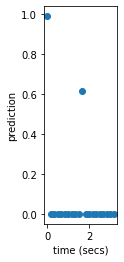

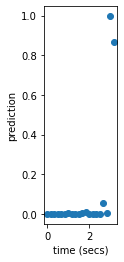

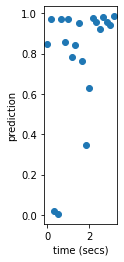

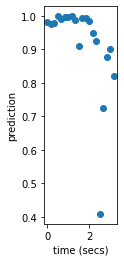

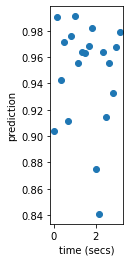

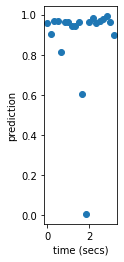

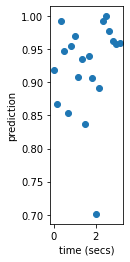

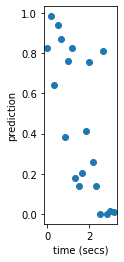

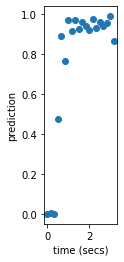

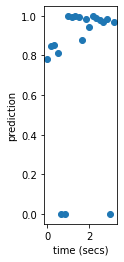

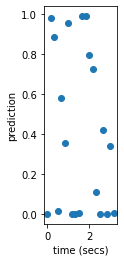

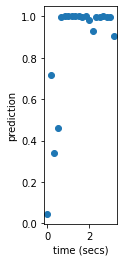

[0.9753598]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


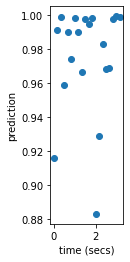

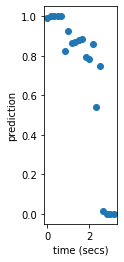

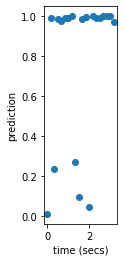

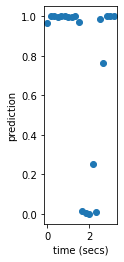

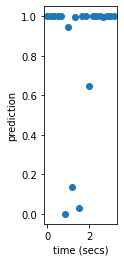

[0.97624743]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


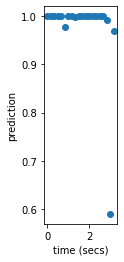

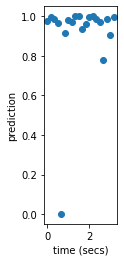

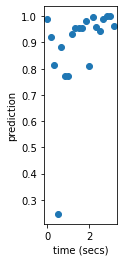

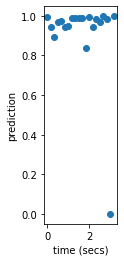

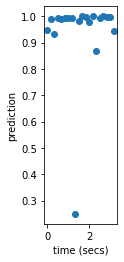

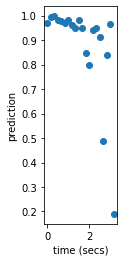

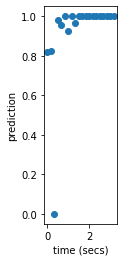

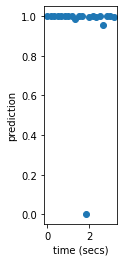

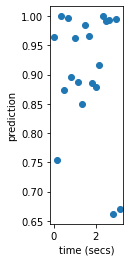

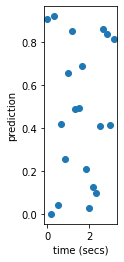

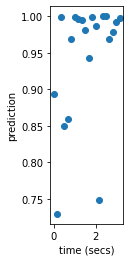

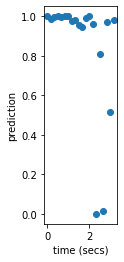

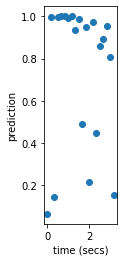

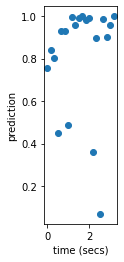

[0.9547164]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


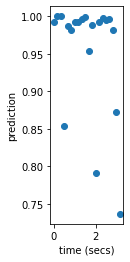

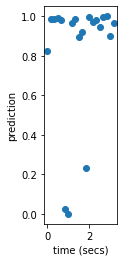

[0.9582183]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


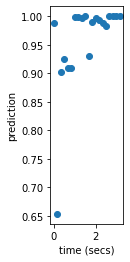

[0.9869628]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


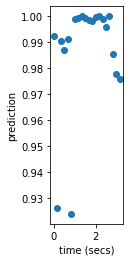

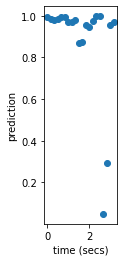

[0.9881171]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


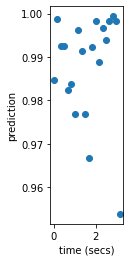

[0.9942889]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


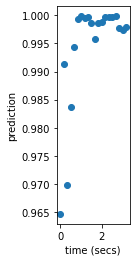

[0.9920951]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


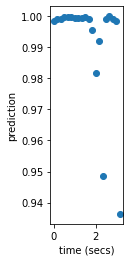

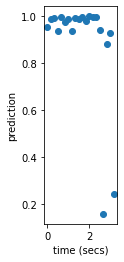

[0.9818994]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


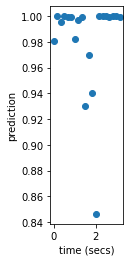

[0.9964207]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


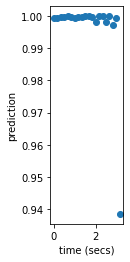

[0.9771519]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


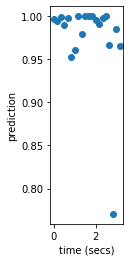

[0.99830806]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


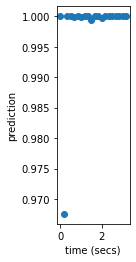

[0.9998881]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


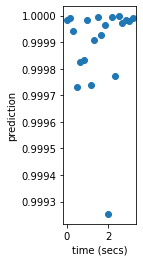

[0.99840134]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


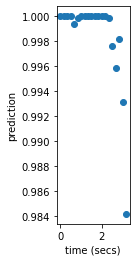

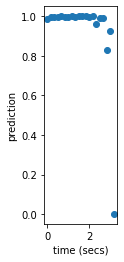

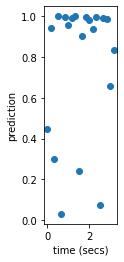

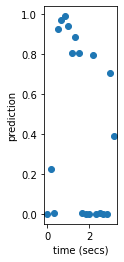

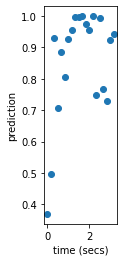

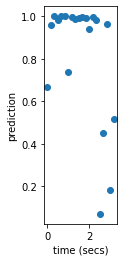

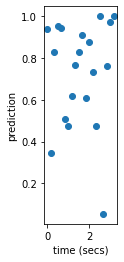

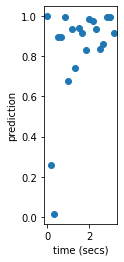

[0.9953192]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


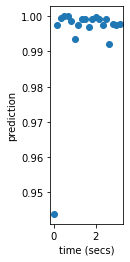

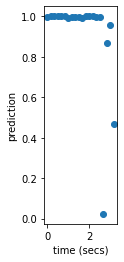

[0.9835614]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


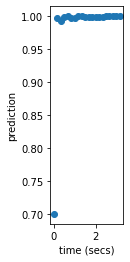

[0.9935688]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


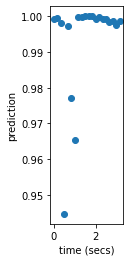

[0.99536055]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


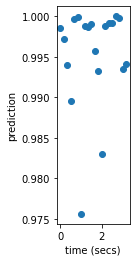

[0.9976465]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


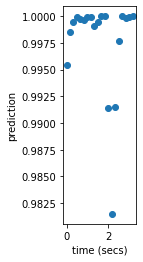

[0.9968339]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


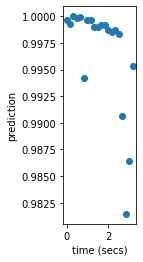

[0.9950876]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


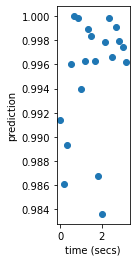

[0.99681616]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


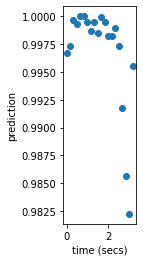

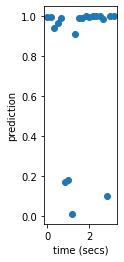

[0.9993717]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


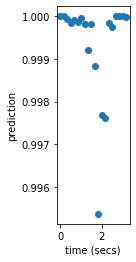

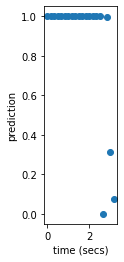

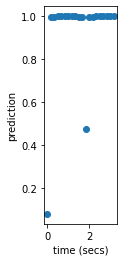

[0.99997437]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


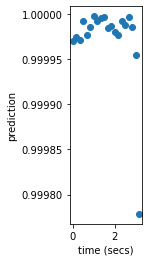

[0.999982]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


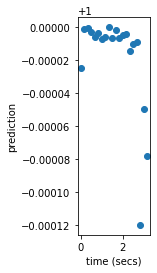

[0.999818]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


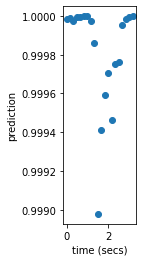

[0.9593379]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


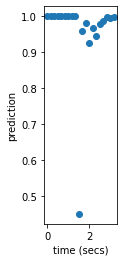

[0.9887163]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


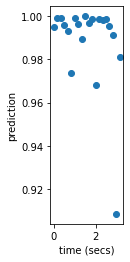

[0.98129624]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


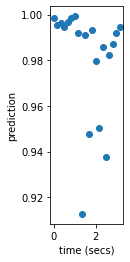

[0.991405]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


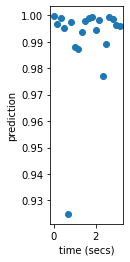

[0.9976923]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


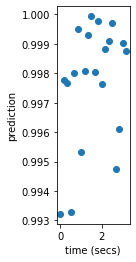

[0.98476744]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


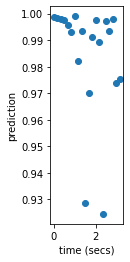

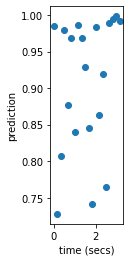

[0.9567752]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


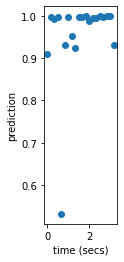

[0.9938059]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


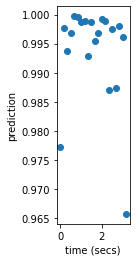

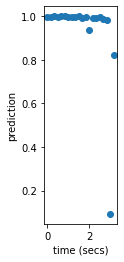

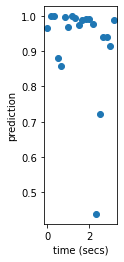

[0.95733374]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


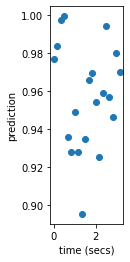

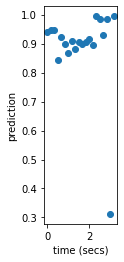

[0.9784382]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


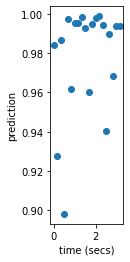

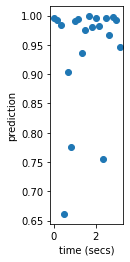

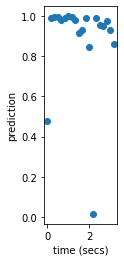

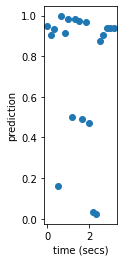

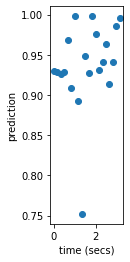

[0.96642363]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


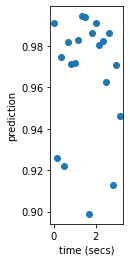

[0.97032976]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


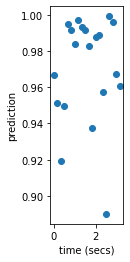

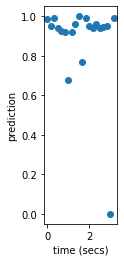

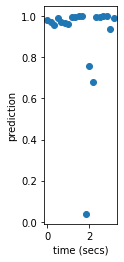

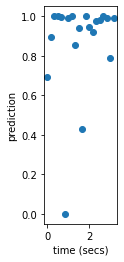

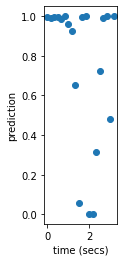

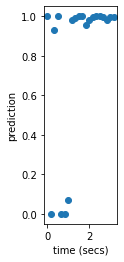

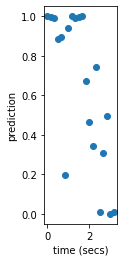

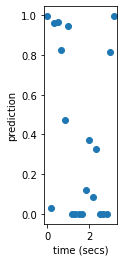

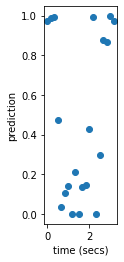

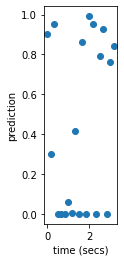

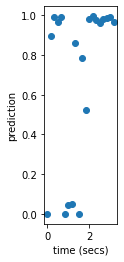

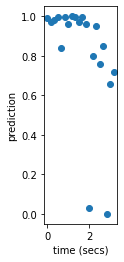

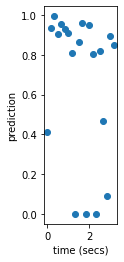

[0.95461863]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


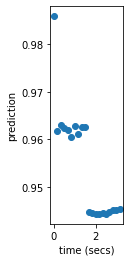

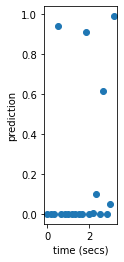

[0.95998514]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


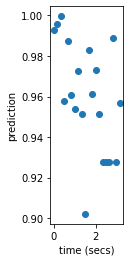

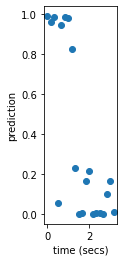

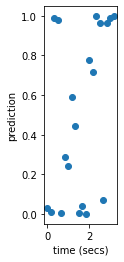

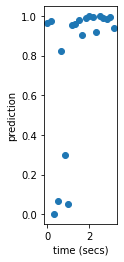

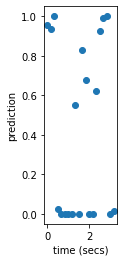

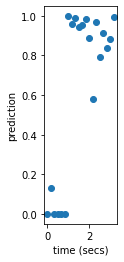

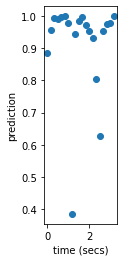

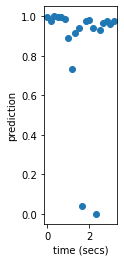

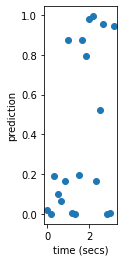

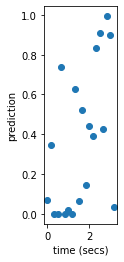

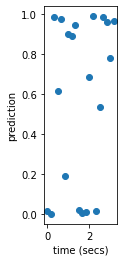

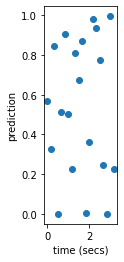

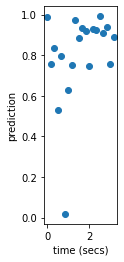

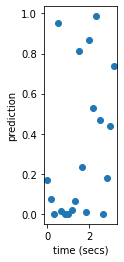

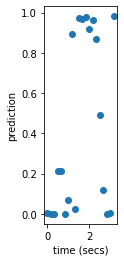

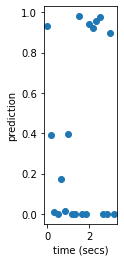

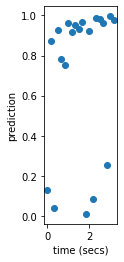

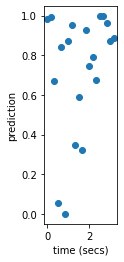

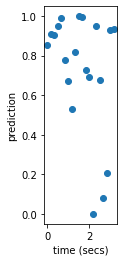

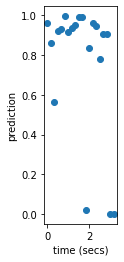

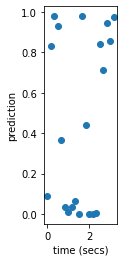

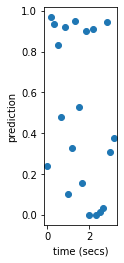

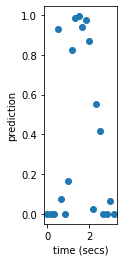

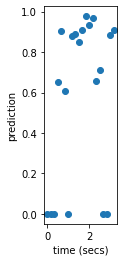

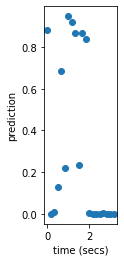

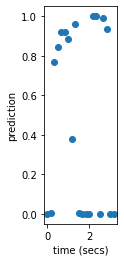

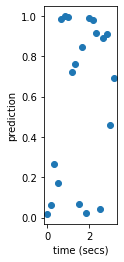

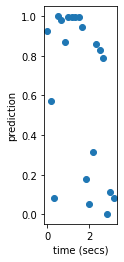

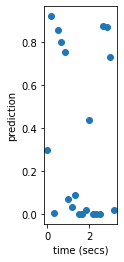

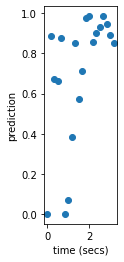

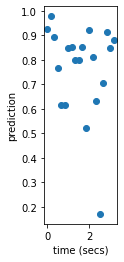

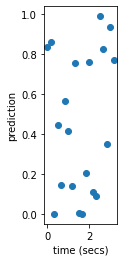

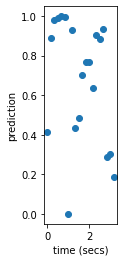

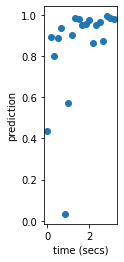

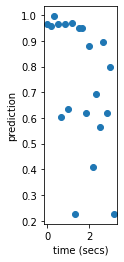

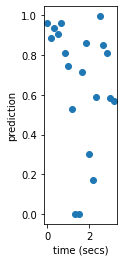

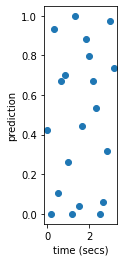

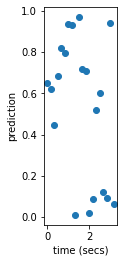

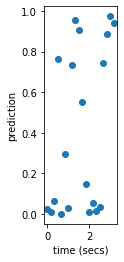

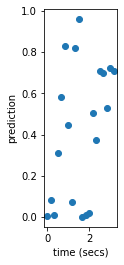

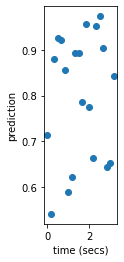

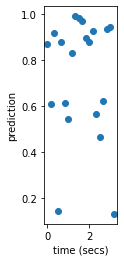

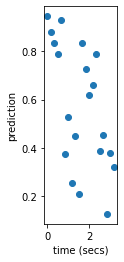

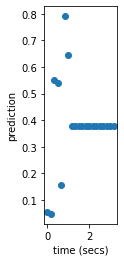

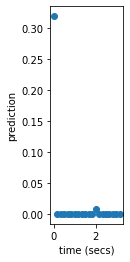

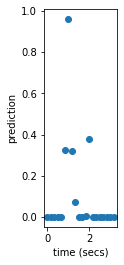

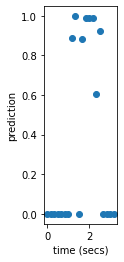

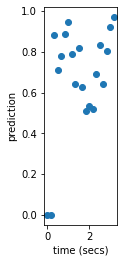

[0.9596788]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


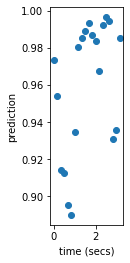

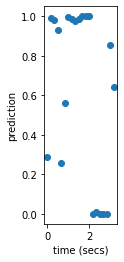

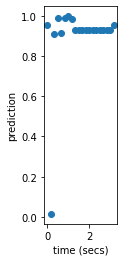

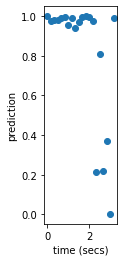

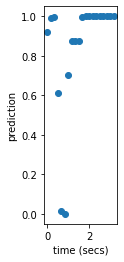

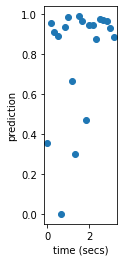

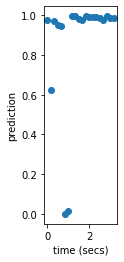

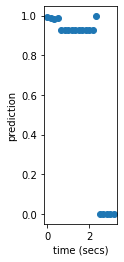

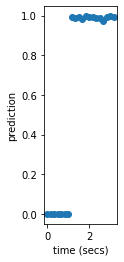

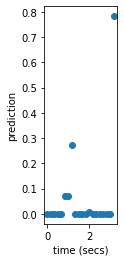

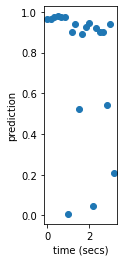

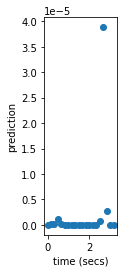

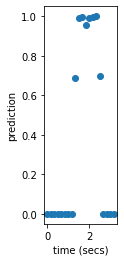

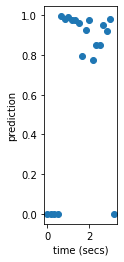

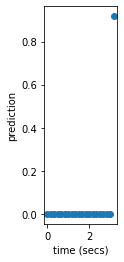

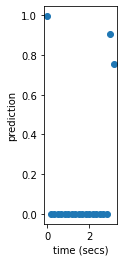

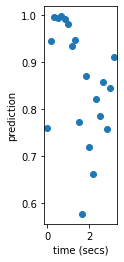

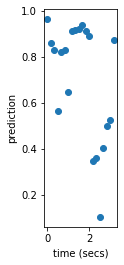

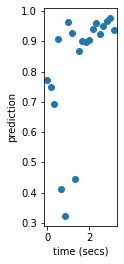

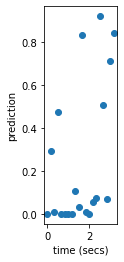

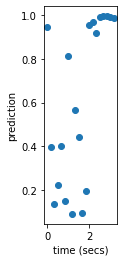

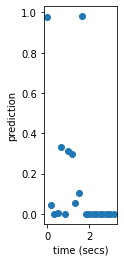

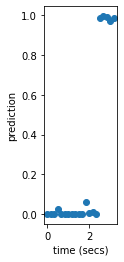

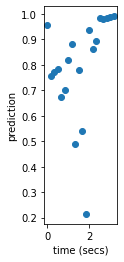

[0.9657356]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


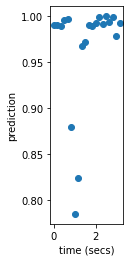

[0.97690076]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


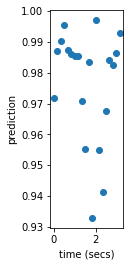

[0.98722935]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


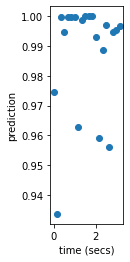

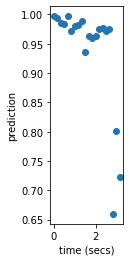

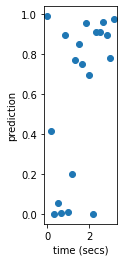

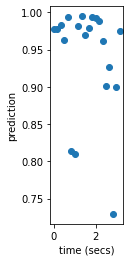

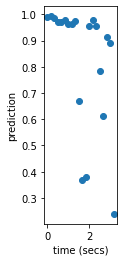

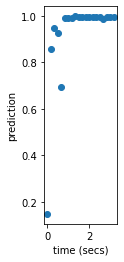

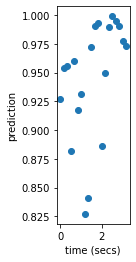

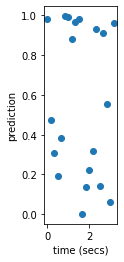

[0.9898528]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


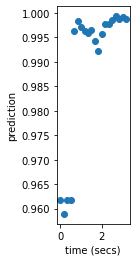

[0.9903635]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


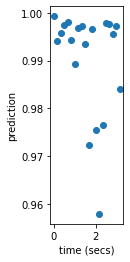

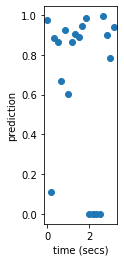

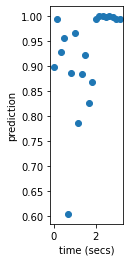

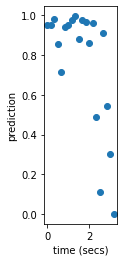

[0.95543563]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


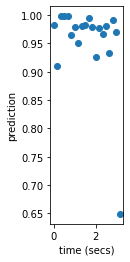

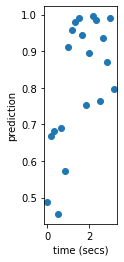

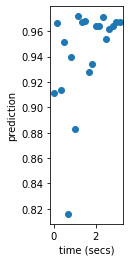

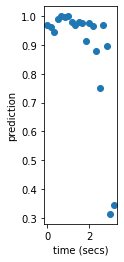

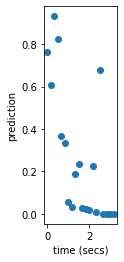

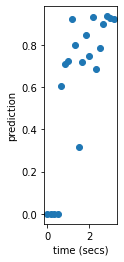

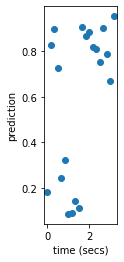

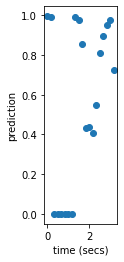

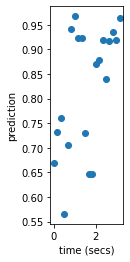

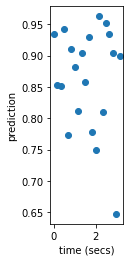

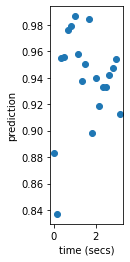

[0.95327693]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


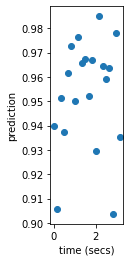

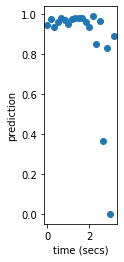

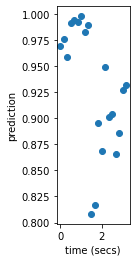

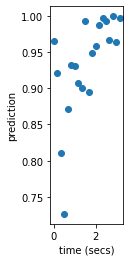

[0.9758853]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


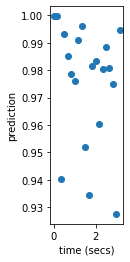

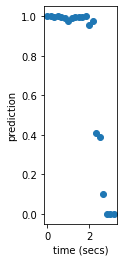

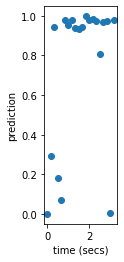

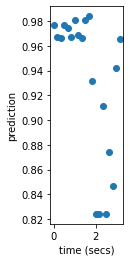

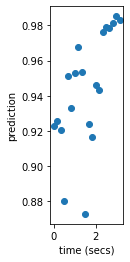

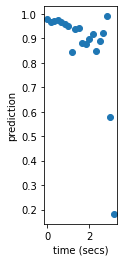

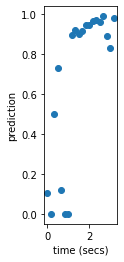

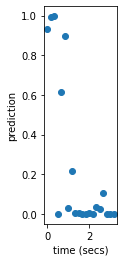

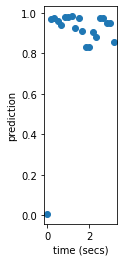

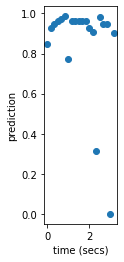

[0.9778296]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


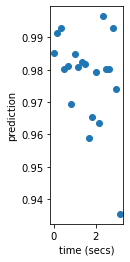

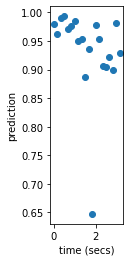

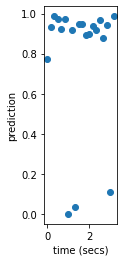

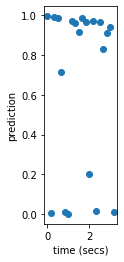

[0.9656943]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


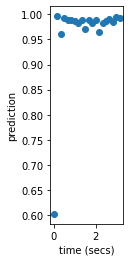

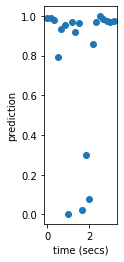

[0.9759043]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


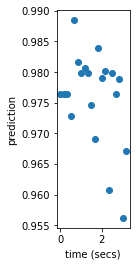

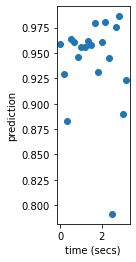

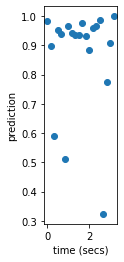

[0.99404174]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


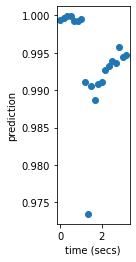

[0.99035674]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


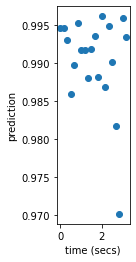

[0.9919176]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


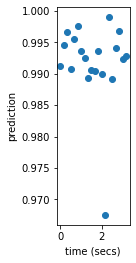

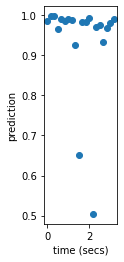

[0.98981017]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


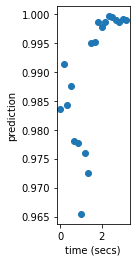

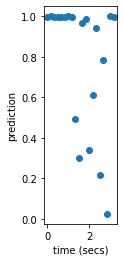

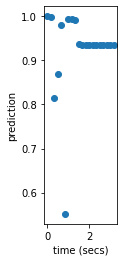

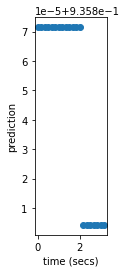

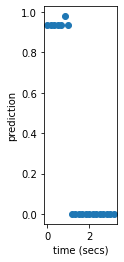

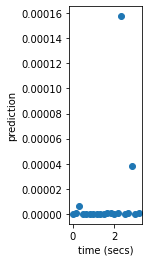

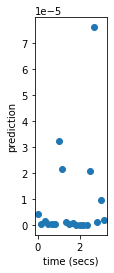

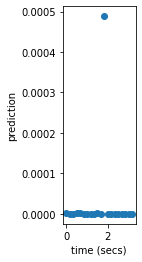

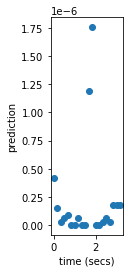

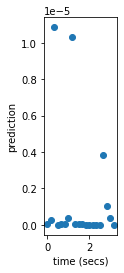

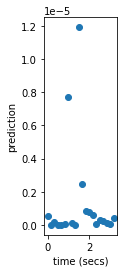

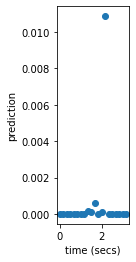

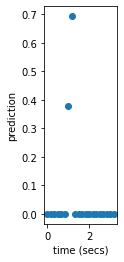

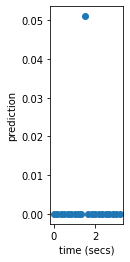

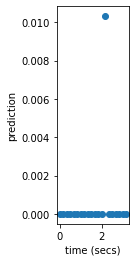

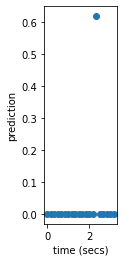

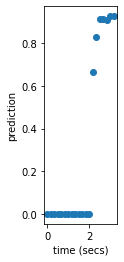

[0.95781344]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


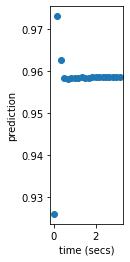

[0.9538662]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


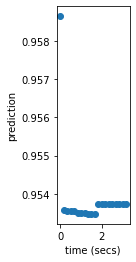

[0.9567299]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


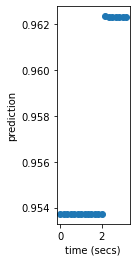

[0.96229917]
time: [0.         0.16683333 0.33366667 0.5005     0.66733333 0.83416667
 1.001      1.16783333 1.33466667 1.5015     1.66833333 1.83516667
 2.002      2.16883333 2.33566667 2.5025     2.66933333 2.83616667
 3.003      3.16983333]


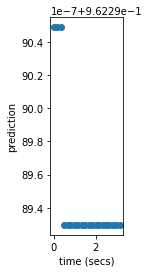

[0.999997]
time: [0.         0.16666667 0.33333333 0.5        0.66666667 0.83333333
 1.         1.16666667 1.33333333 1.5        1.66666667 1.83333333
 2.         2.16666667 2.33333333 2.5        2.66666667 2.83333333
 3.         3.16666667]


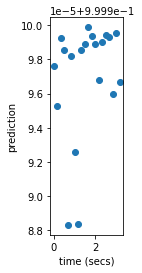

[0.9666511]
time: [0.         0.16666667 0.33333333 0.5        0.66666667 0.83333333
 1.         1.16666667 1.33333333 1.5        1.66666667 1.83333333
 2.         2.16666667 2.33333333 2.5        2.66666667 2.83333333
 3.         3.16666667]


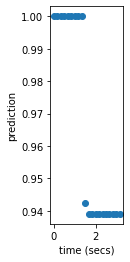

[0.9668822]
time: [0.         0.16666667 0.33333333 0.5        0.66666667 0.83333333
 1.         1.16666667 1.33333333 1.5        1.66666667 1.83333333
 2.         2.16666667 2.33333333 2.5        2.66666667 2.83333333
 3.         3.16666667]


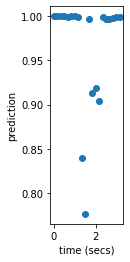

[0.9989088]
time: [0.         0.16666667 0.33333333 0.5        0.66666667 0.83333333
 1.         1.16666667 1.33333333 1.5        1.66666667 1.83333333
 2.         2.16666667 2.33333333 2.5        2.66666667 2.83333333
 3.         3.16666667]


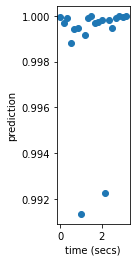

[0.9653441]
time: [0.         0.16666667 0.33333333 0.5        0.66666667 0.83333333
 1.         1.16666667 1.33333333 1.5        1.66666667 1.83333333
 2.         2.16666667 2.33333333 2.5        2.66666667 2.83333333
 3.         3.16666667]


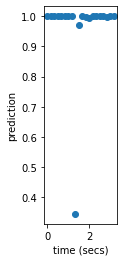

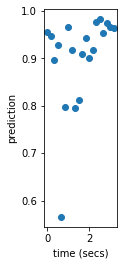

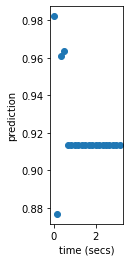

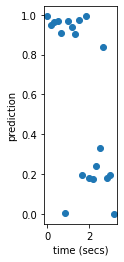

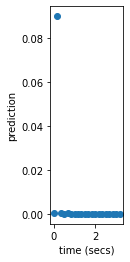

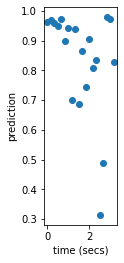

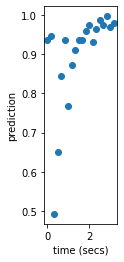

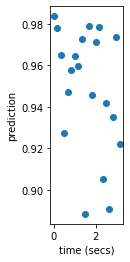

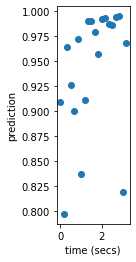

[0.9612632]
time: [0.         0.16666667 0.33333333 0.5        0.66666667 0.83333333
 1.         1.16666667 1.33333333 1.5        1.66666667 1.83333333
 2.         2.16666667 2.33333333 2.5        2.66666667 2.83333333
 3.         3.16666667]


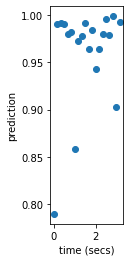

[0.9809737]
time: [0.         0.16666667 0.33333333 0.5        0.66666667 0.83333333
 1.         1.16666667 1.33333333 1.5        1.66666667 1.83333333
 2.         2.16666667 2.33333333 2.5        2.66666667 2.83333333
 3.         3.16666667]


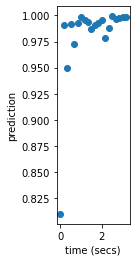

[0.95893556]
time: [0.         0.16666667 0.33333333 0.5        0.66666667 0.83333333
 1.         1.16666667 1.33333333 1.5        1.66666667 1.83333333
 2.         2.16666667 2.33333333 2.5        2.66666667 2.83333333
 3.         3.16666667]


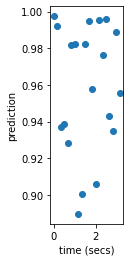

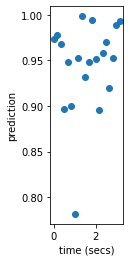

[0.9842159]
time: [0.         0.16666667 0.33333333 0.5        0.66666667 0.83333333
 1.         1.16666667 1.33333333 1.5        1.66666667 1.83333333
 2.         2.16666667 2.33333333 2.5        2.66666667 2.83333333
 3.         3.16666667]


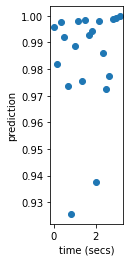

[0.95817393]
time: [0.         0.16666667 0.33333333 0.5        0.66666667 0.83333333
 1.         1.16666667 1.33333333 1.5        1.66666667 1.83333333
 2.         2.16666667 2.33333333 2.5        2.66666667 2.83333333
 3.         3.16666667]


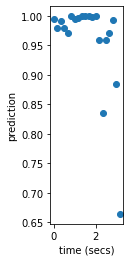

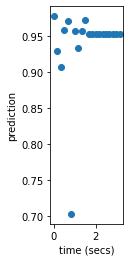

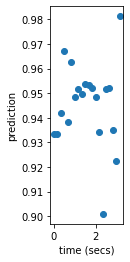

[0.98135626]
time: [0.         0.16666667 0.33333333 0.5        0.66666667 0.83333333
 1.         1.16666667 1.33333333 1.5        1.66666667 1.83333333
 2.         2.16666667 2.33333333 2.5        2.66666667 2.83333333
 3.         3.16666667]


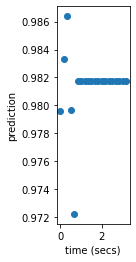

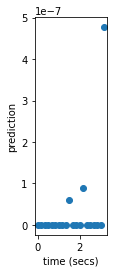

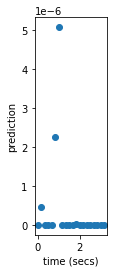

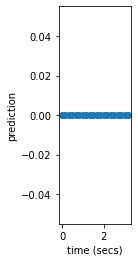

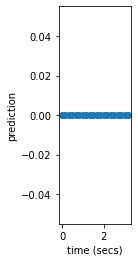

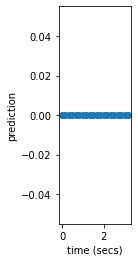

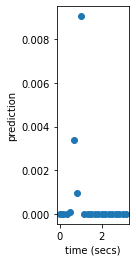

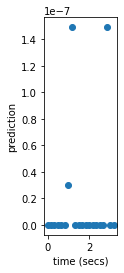

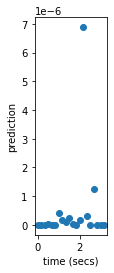

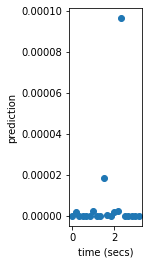

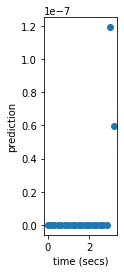

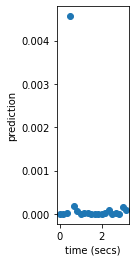

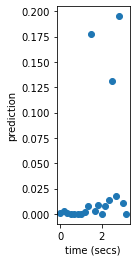

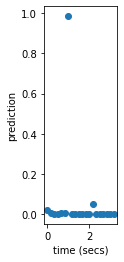

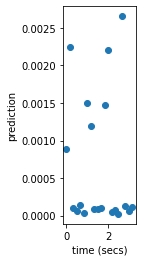

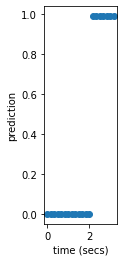

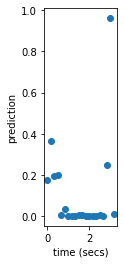

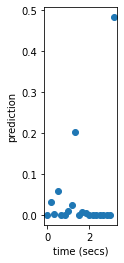

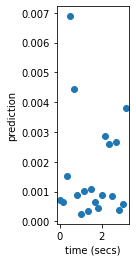

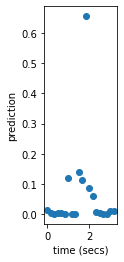

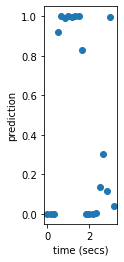

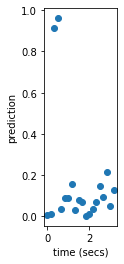

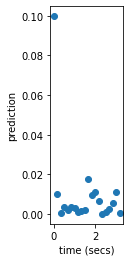

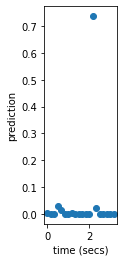

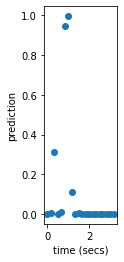

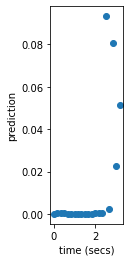

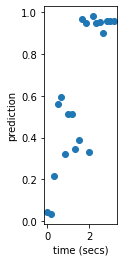

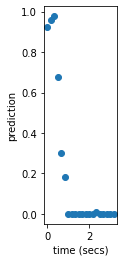

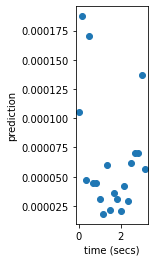

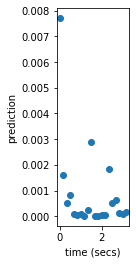

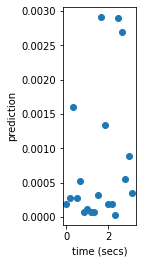

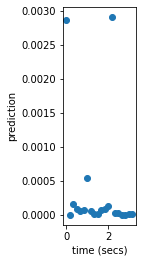

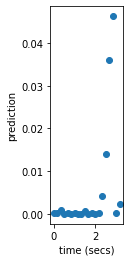

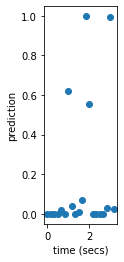

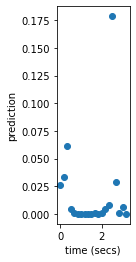

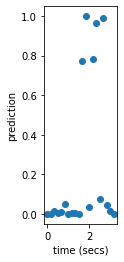

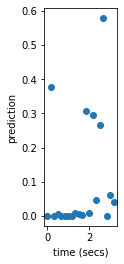

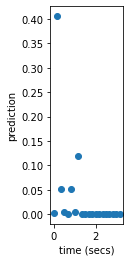

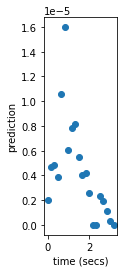

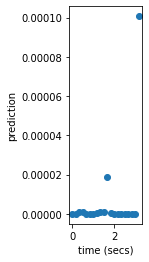

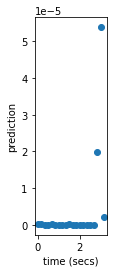

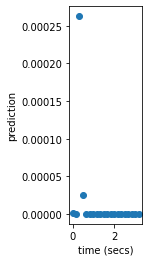

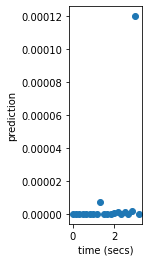

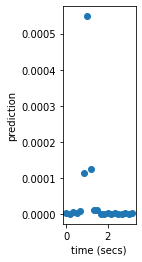

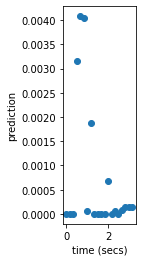

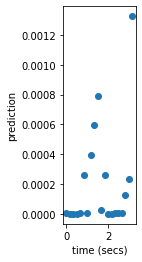

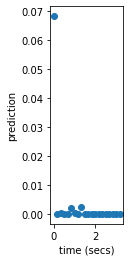

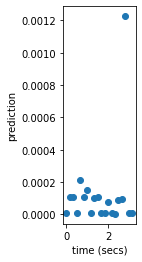

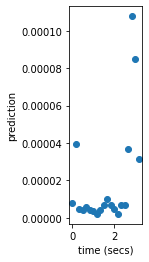

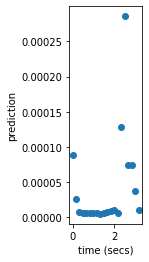

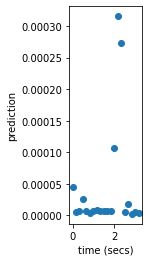

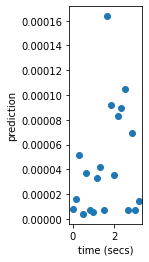

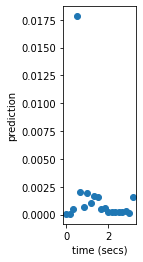

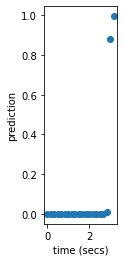

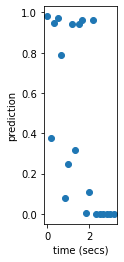

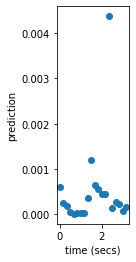

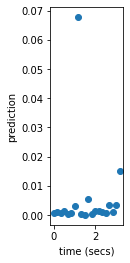

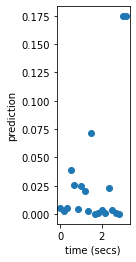

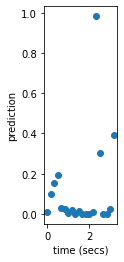

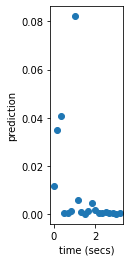

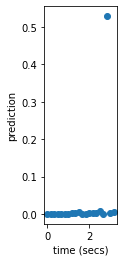

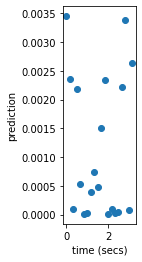

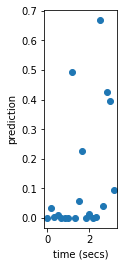

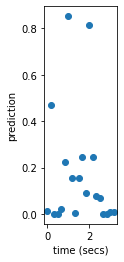

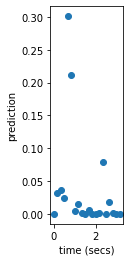

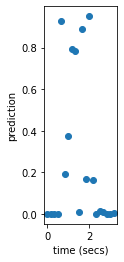

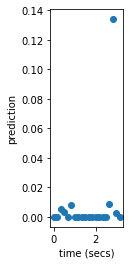

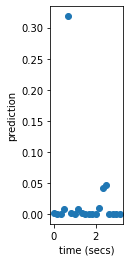

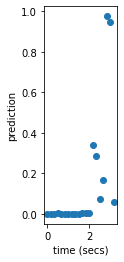

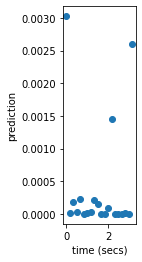

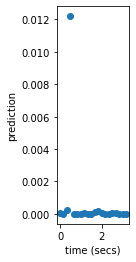

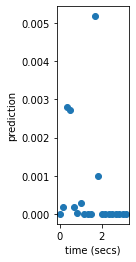

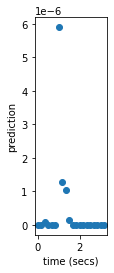

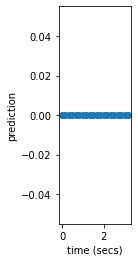

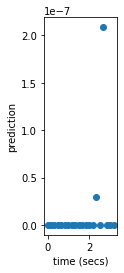

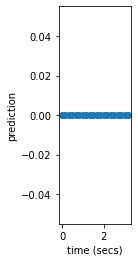

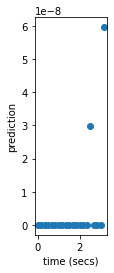

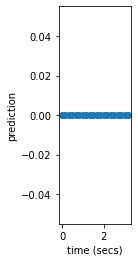

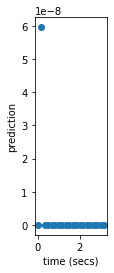

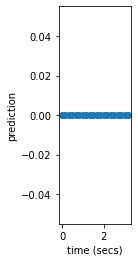

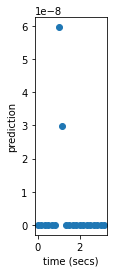

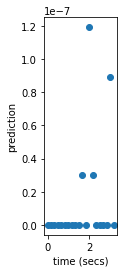

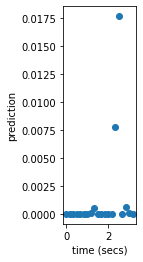

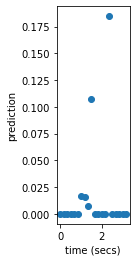

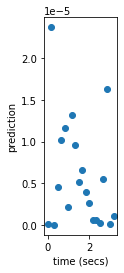

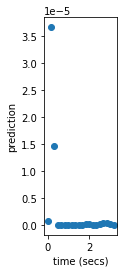

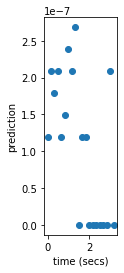

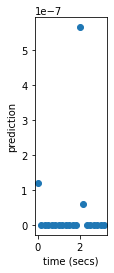

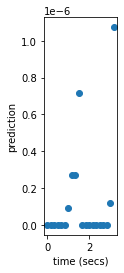

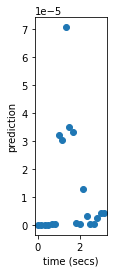

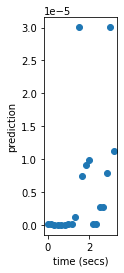

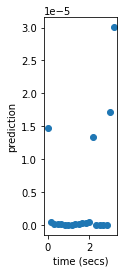

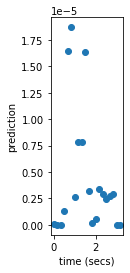

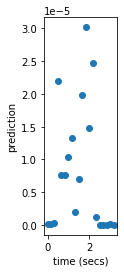

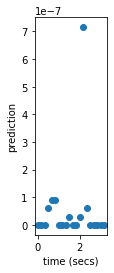

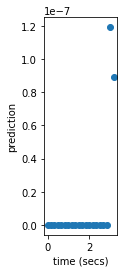

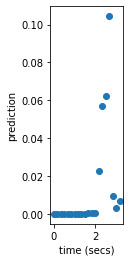

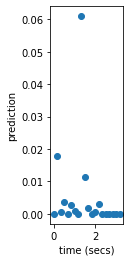

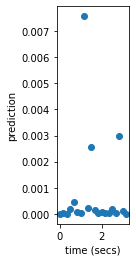

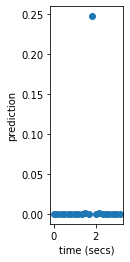

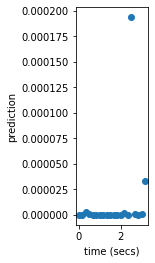

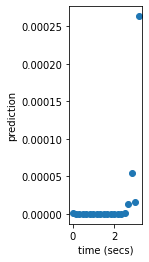

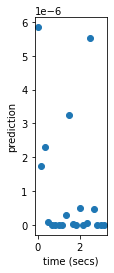

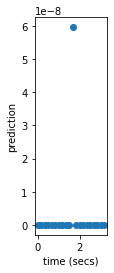

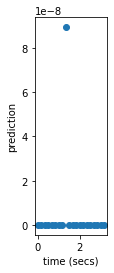

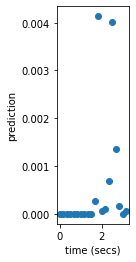

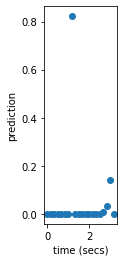

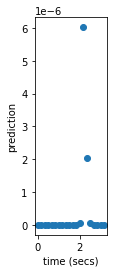

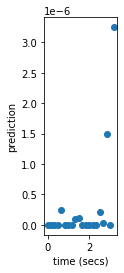

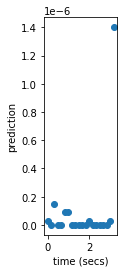

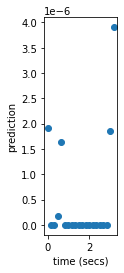

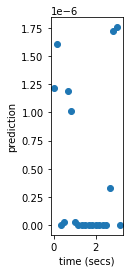

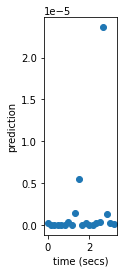

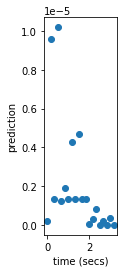

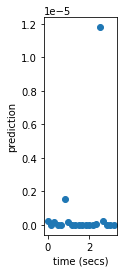

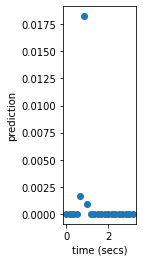

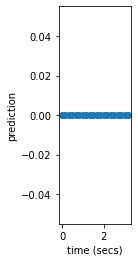

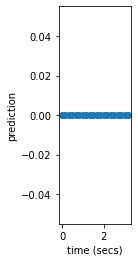

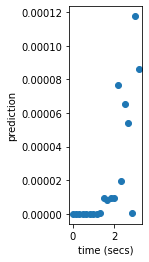

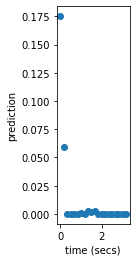

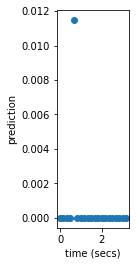

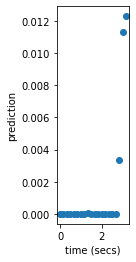

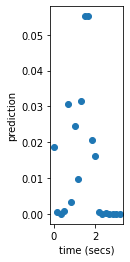

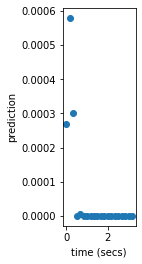

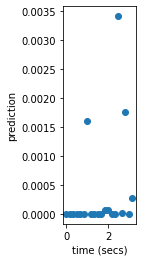

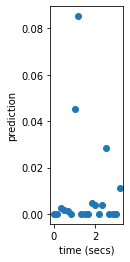

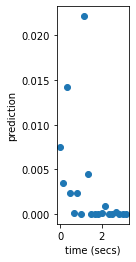

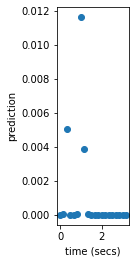

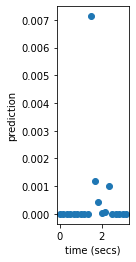

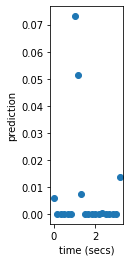

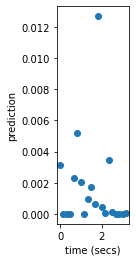

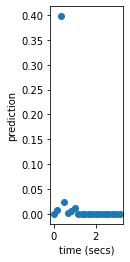

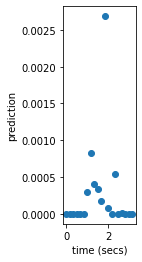

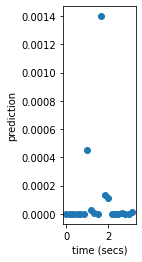

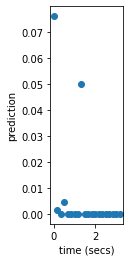

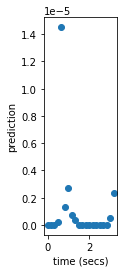

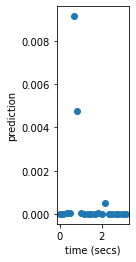

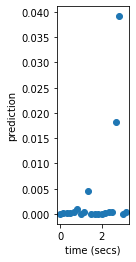

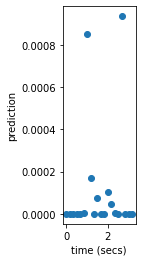

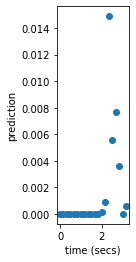

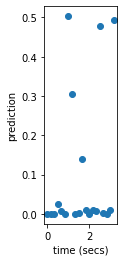

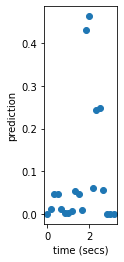

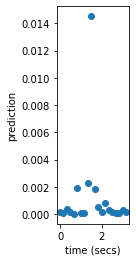

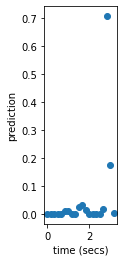

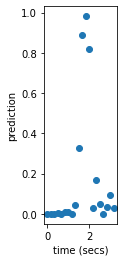

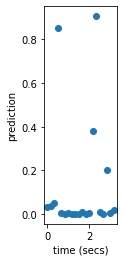

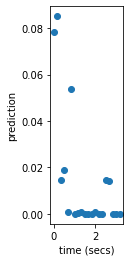

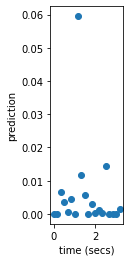

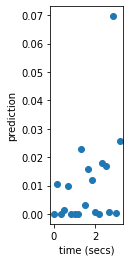

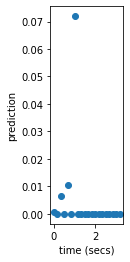

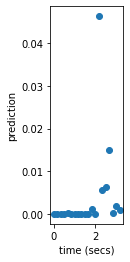

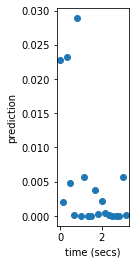

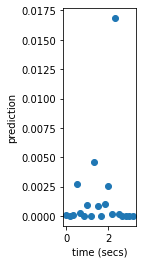

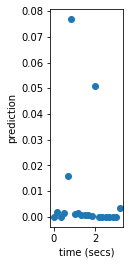

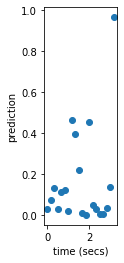

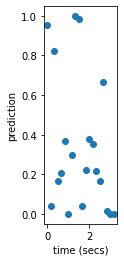

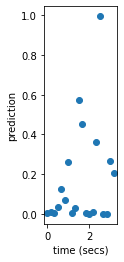

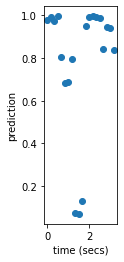

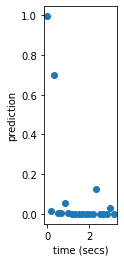

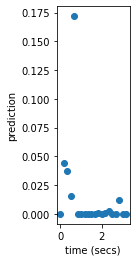

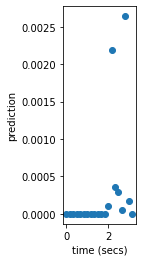

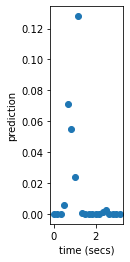

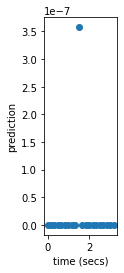

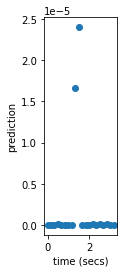

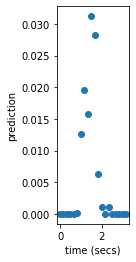

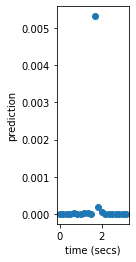

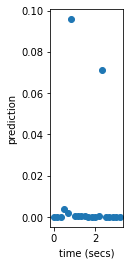

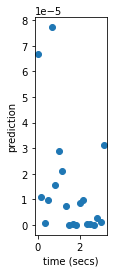

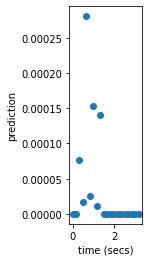

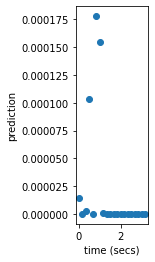

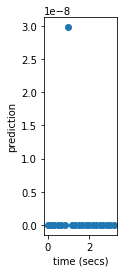

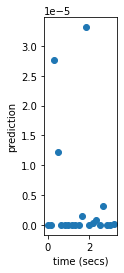

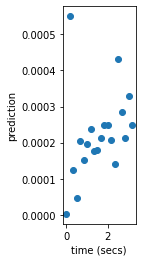

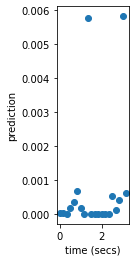

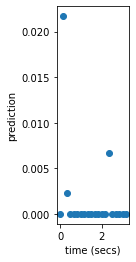

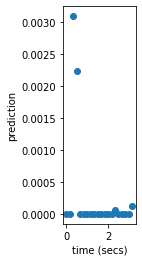

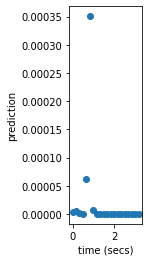

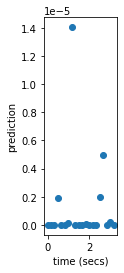

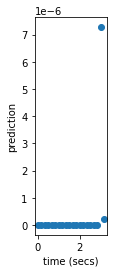

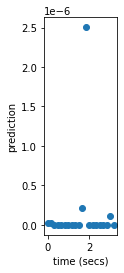

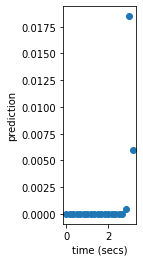

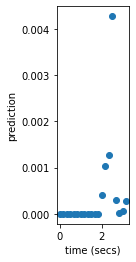

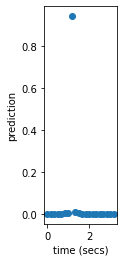

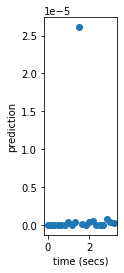

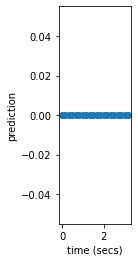

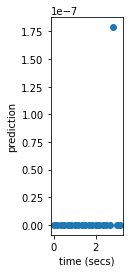

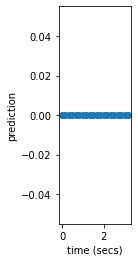

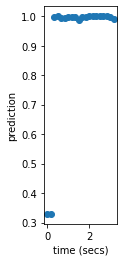

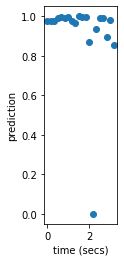

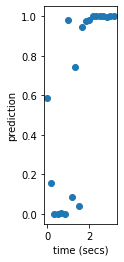

[0.9998579]
time: [0.         0.16666667 0.33333333 0.5        0.66666667 0.83333333
 1.         1.16666667 1.33333333 1.5        1.66666667 1.83333333
 2.         2.16666667 2.33333333 2.5        2.66666667 2.83333333
 3.         3.16666667]


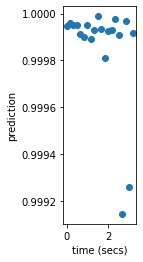

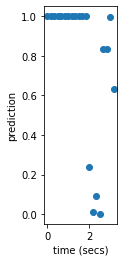

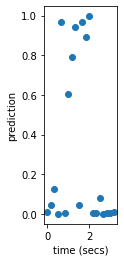

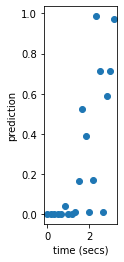

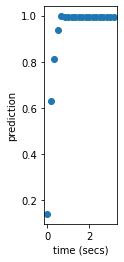

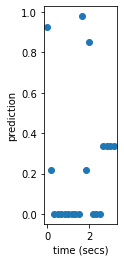

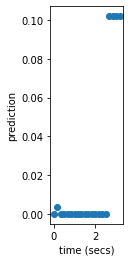

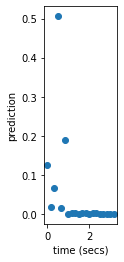

In [47]:
for i in range(len(videos_3d)):
  # ind = list(np.random.randint(0,len(videos_3d)-1,size=len(videos_3d)))
  videos_3d_temp = videos_3d[i]
  videos_2d_shuffled = np.reshape(videos_3d_temp, (-1,224,224,3))
  videos_2d_shuffled = videos_2d_shuffled[:len(videos_2d_shuffled):frame_rate]

  time_3d_temp = time_3d[i]
  time_2d_shuffled = np.reshape(time_3d_temp, (-1,1))
  time_2d_shuffled = time_2d_shuffled[:len(time_2d_shuffled):frame_rate]
  time_2d_shuffled = time_2d_shuffled.T[0]

  labels_2d_temp = labels_2d[i]
  labels_2d_shuffled = labels_2d_temp.flatten()
  labels_2d_shuffled = labels_2d_shuffled[:len(labels_2d_shuffled):frame_rate]


  u_test = ResNet50_loaded.predict(videos_2d_shuffled)
  clip_length = int(num_frames/frame_rate)
  num_vid_parts = int((len(u_test)/clip_length))
          
  num_col = 4
  num_row = math.ceil(num_vid_parts/num_col)

  conf=[]
  sec_per_batch = 2
  for i in np.arange(int((len(u_test)/clip_length))):
      
      plt.figure()
      time = time_2d_shuffled[i*clip_length: (i+1)*clip_length] + i*sec_per_batch
      plt.subplot(num_row, num_col, i+1)
      conf=u_test[i*clip_length: (i+1)*clip_length]
      ave_conf=sum(conf)/len(conf)
      if ave_conf > 0.95:
        print(ave_conf)
        print('time:',time)
        start=time[0]
        end=time[-1]



        "videoId": id,
        "type": "segment",
        "startTime": 0.00,
        "endTime": 0.01,
        "observer": "CSCE636-Spring2021-Baharealik-v3",
        "isHuman": true,
        "label": "cutting",
        "labelConfidence": 0.95
        # plt.scatter(x = time, y = u_test[i*clip_length: (i+1)*clip_length])
  #       if i == 0:
  #           plt.xlabel("time (secs)")
  #           plt.ylabel("prediction")
  # plt.show()  

In [25]:
import pytictoc

time_print = pytictoc.TicToc()
time_print.tic()
print(time_print)
videos = []
labels_2d = []
num_frames = 100
frame_rate = 5
time_3d = []
time_2d = []
i=0
for path in range(2):
  
  vidcap = cv2.VideoCapture(path_test)
  fps = vidcap.get(cv2.CAP_PROP_FPS)
  success, image = vidcap.read()
  frames = []
  

  time = []
  count = 0  # control to have the same number of frames
  count_fps = 0
  while success:
    
    
    success, image = vidcap.read()
    count += 1
    if(type(image).__module__ == np.__name__):
      new_image = cv2.resize(image, (224,224), interpolation = cv2.INTER_AREA)
      
      frames.append(new_image)
      time.append(count_fps*(1/fps))
      count_fps += 1
      if count==num_frames:
        count_fps = 0
        print("Frames_", str(count),", video_", str(i), "Done, Time_Elapsed: ", str(round(time_print.tocvalue(),3)), " Seconds")
        videos.append(frames)
        time_3d.append(time)
        count = 0
        frames = []
        time = []

  if (count < num_frames):
    while (count > 0 and count <= num_frames):
      frames.append(new_image)    # if the number of frames is lower than the num_frames, repeat the last image to reach num_frames
      count +=1
      time.append(count_fps*(1/fps))
      count_fps += 1
      
    videos.append(frames)
    time_3d.append(time)
  
  i+=1
  print("Video_", str(i),"Done, Time_Elapsed: ", str(round(time_print.tocvalue(),3)), " Seconds")


videos_2d_len = len(videos)
videos_3d = np.array(videos)

labels_2d = np.zeros((len(videos_3d),num_frames))
labels_2d[0:videos_2d_len,:] = 1

time_3d = np.array(time_3d)

Frames_ 100 , video_ 0 Done, Time_Elapsed:  1.722  Seconds
Video_ 1 Done, Time_Elapsed:  1.916  Seconds
Frames_ 100 , video_ 1 Done, Time_Elapsed:  2.709  Seconds
Video_ 2 Done, Time_Elapsed:  2.9  Seconds


In [26]:
# ind = list(np.random.randint(0,len(videos_3d)-1,size=len(videos_3d)))
videos_3d_temp = videos_3d
videos_2d_shuffled = np.reshape(videos_3d_temp, (-1,224,224,3))
videos_2d_shuffled = videos_2d_shuffled[:len(videos_2d_shuffled):frame_rate]

time_3d_temp = time_3d
time_2d_shuffled = np.reshape(time_3d_temp, (-1,1))
time_2d_shuffled = time_2d_shuffled[:len(time_2d_shuffled):frame_rate]
time_2d_shuffled = time_2d_shuffled.T[0]

labels_2d_temp = labels_2d
labels_2d_shuffled = labels_2d_temp.flatten()
labels_2d_shuffled = labels_2d_shuffled[:len(labels_2d_shuffled):frame_rate]

In [27]:
u_test = ResNet50_loaded.predict(videos_2d_shuffled)

In [ ]:
frame

20.0

[0.98135644]
time: [2.         2.16666667 2.33333333 2.5        2.66666667 2.83333333
 3.         3.16666667 3.33333333 3.5        3.66666667 3.83333333
 4.         4.16666667 4.33333333 4.5        4.66666667 4.83333333
 5.         5.16666667]
[0.98135644]
time: [6.         6.16666667 6.33333333 6.5        6.66666667 6.83333333
 7.         7.16666667 7.33333333 7.5        7.66666667 7.83333333
 8.         8.16666667 8.33333333 8.5        8.66666667 8.83333333
 9.         9.16666667]


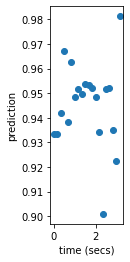

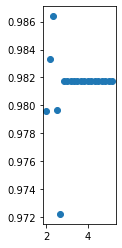

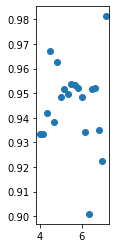

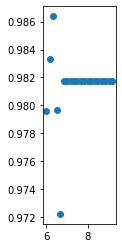

In [43]:
clip_length = int(num_frames/frame_rate)
num_vid_parts = int((len(u_test)/clip_length))
        
num_col = 4
num_row = math.ceil(num_vid_parts/num_col)

conf=[]
sec_per_batch = 2
for i in np.arange(int((len(u_test)/clip_length))):
    
    plt.figure()
    time = time_2d_shuffled[i*clip_length: (i+1)*clip_length] + i*sec_per_batch
    plt.subplot(num_row, num_col, i+1)
    conf=u_test[i*clip_length: (i+1)*clip_length]
    ave_conf=sum(conf)/len(conf)
    if ave_conf > 0.95:
      print(ave_conf)
      print('time:',time)
    plt.scatter(x = time, y = u_test[i*clip_length: (i+1)*clip_length])
    
    if i == 0:
        plt.xlabel("time (secs)")
        plt.ylabel("prediction")
plt.show()  
# print(conf.shape)
# for i in range(len(conf))
#   print(sum(conf[i][0])/len(conf[i]))

Text(0.5, 0, 'frame number')

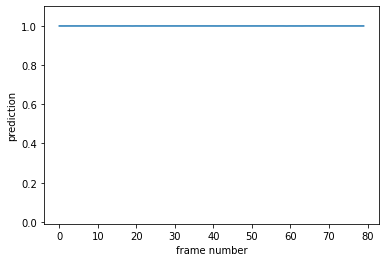

In [ ]:
# frame = num_frames/frame_rate
# xxx = np.arange(0, 19, 1/frame)
# plt.plot(xxx, u_test)
plt.plot(u_test)
plt.ylim(-.01,1.1)
plt.ylabel('prediction')
plt.xlabel('frame number')

In [ ]:
#Download json file
import json
jsonContent = []
jsonContent.append({"videoId":"fztw1S4qpjA",
                                "type":"segment",
                                # "startTime":round(num_frames/frame_rate,2),
                                # "endTime":round(num_frames/frame_rate,2),
                                # "startTime":0.00,
                                # "endTime":4.28,
                                "observer":"CSCE636-Spring2021-baharealik_v3",
                                "isHuman":False,
                                "confirmedBySomeone": False,
                                "rejectedBySomeone": False,
                                "observation":{"label":"cutting",
                                               "labelConfidence":0.95}})
with open('/content/drive/My Drive/CSCE636/JSON/new.json', 'w') as json_file:
    json.dump(jsonContent, jsonfile)

FileNotFoundError: ignored

Finding youtube videos

In [ ]:

#Search for Youtube videos
# !pip install pytube
# !pip install youtubesearchpython
# # from youtubesearchpython import VideosSearch
# !pip install youtube_searchimport os
from youtube_search import YoutubeSearch
from pytube import YouTube
!pip install youtube-search-python
from youtubesearchpython import VideosSearch
!pip install youtube_dl
from __future__ import unicode_literals
import youtube_dl


     |████████████████████████████████| 71kB 4.5MB/s 
     |████████████████████████████████| 71kB 5.1MB/s 
     |████████████████████████████████| 61kB 3.9MB/s 
     |████████████████████████████████| 61kB 6.2MB/s 


In [ ]:
import pytube  
from pytube import YouTube  
import urllib.request
# yt = YouTube("https://www.youtube.com/watch?v=n06H7OcPd-g")
# yt = yt.get('mp4', '720p')
# yt.download('/path/to/download/directory')
searchIDs=['slice fruit','vegetables cutting skill', 'fruit cutting', 'cooking cut']
# os.chdir("/content/drive/My Drive/CSCE636/3_test_Youtube")
downVid=[]
for searchID in searchIDs:
    vidSearch = VideosSearch(searchID, limit=2)
    print(searchID)
    id=vidSearch.result()['result'][0]['id']
    url='https://www.youtube.com/watch?v='+id
    print(url)
    youtube = pytube.YouTube(url)  
    video = youtube.streams.first()  
    video.download('/content/drive/My Drive/CSCE636/3_test_Youtube')   


slice fruit
https://www.youtube.com/watch?v=VjINuQX4hbM
vegetables cutting skill
https://www.youtube.com/watch?v=The6vuJocTI
fruit cutting
https://www.youtube.com/watch?v=3lXlwRCjYLg
cooking cut
https://www.youtube.com/watch?v=G-Fg7l7G1zw
